 # Google Trace Project

In [29]:
!which python

/mnt/lustre/scratch/nlsas/home/ulc/cursos/curso341/miniconda3/envs/DaskOnRay38/bin/python


In [30]:
%pip install seaborn #seaborn n'est parfois pas détecté par le notebook


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /mnt/netapp2/Store_uni/home/ulc/cursos/curso341/mypython/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1. Initialisation et Chargement des Données

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, BooleanType, StringType
import matplotlib.pyplot as plt
import seaborn as sns

## Task Usage

In [32]:
# Création de la session Spark
spark = SparkSession.builder \
    .appName("Analyse Google Cluster Trace") \
    .getOrCreate()

In [33]:
#############################################
# Chargement des données task_usage
#############################################

# Définition du schéma pour task_usage (renommage des colonnes pour faciliter la manipulation)
schema_task_usage = StructType([
    StructField("start_time", IntegerType(), True),
    StructField("end_time", IntegerType(), True),
    StructField("job_id", IntegerType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", IntegerType(), True),
    StructField("cpu_rate", FloatType(), True),
    StructField("canonical_memory_usage", FloatType(), True),
    StructField("assigned_memory_usage", FloatType(), True),
    StructField("unmapped_page_cache", FloatType(), True),
    StructField("total_page_cache", FloatType(), True),
    StructField("max_memory_usage", FloatType(), True),
    StructField("disk_io_time", FloatType(), True),
    StructField("local_disk_space_usage", FloatType(), True),
    StructField("max_cpu_rate", FloatType(), True),
    StructField("max_disk_io_time", FloatType(), True),
    StructField("cycles_per_instruction", FloatType(), True),
    StructField("memory_accesses_per_instruction", FloatType(), True),
    StructField("sample_portion", FloatType(), True),
    StructField("aggregation_type", BooleanType(), True),
    StructField("sampled_cpu_usage", FloatType(), True)
])

# Chemin d'accès aux fichiers CSV (ajustez le chemin selon votre environnement)
task_usage_path = "data/task_usage/*.csv"
# task_usage_path = "data/task_usage/part-00003-of-00500.csv"

# Lecture des données task_usage
df_task_usage = spark.read.csv(task_usage_path, header=False, schema=schema_task_usage)
print("Nombre de lignes brutes dans task_usage :", df_task_usage.count())
df_task_usage.show(5)

Nombre de lignes brutes dans task_usage : 1232799308
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+
|start_time| end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--

# 2. Nettoyage et Préparation des Données task_usage

In [34]:
# Nettoyage des données : suppression des lignes où job_id est null ou les consommations sont à 0
df_task_usage_clean = df_task_usage.filter(
    (F.col("job_id").isNotNull()) & 
    (F.col("canonical_memory_usage") > 0) & 
    (F.col("sampled_cpu_usage") > 0)
)
print("Nombre de lignes après nettoyage task_usage :", df_task_usage_clean.count())
df_task_usage_clean.show(5)

# Ajout d'une colonne "duration" pour connaître la durée d'exécution (end_time - start_time)
df_task_usage_clean = df_task_usage_clean.withColumn("duration", F.col("end_time") - F.col("start_time"))
df_task_usage_clean.select("start_time", "end_time", "duration").show(5)

Nombre de lignes après nettoyage task_usage : 7901086
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+
|start_time| end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+-

Nous filtrons les enregistrements en supprimant ceux dont le job_id est nul ou dont la consommation mémoire ou CPU est nulle. Puis, nous calculons la durée d’exécution de chaque enregistrement.

Choix effectués :

Le filtrage sur les valeurs strictement supérieures à 0 permet d’éliminer les enregistrements non significatifs pour l’analyse des ressources.

La durée est utilisée pour pondérer le calcul de la consommation moyenne, ce qui reflète mieux l’impact global de la tâche.

## (Stockage des données filtrées)

Etant donné que les étapes précédentes sont très longue à tourner, nous avons décider de stocker notre dataframe filtré dans un dossier parquet qui sera très simple de lire s'il on veut retravailler sur le projet sans run toutes les cellules précédentes.

In [35]:
# Écriture du DataFrame nettoyé en format Parquet
df_task_usage_clean.write.mode("overwrite").parquet("task_usage_clean.parquet")

25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 89.80% for 8 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 79.83% for 9 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 71.84% for 10 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 65.31% for 11 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 59.87% for 12 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 55.26% for 13 writers
25/02/05 18:36:17 WARN MemoryManager: Total allocation exceeds 95.00% (964,270

Il nous suffit de lire le parquet pour sauter toutes les étapes précédentes.

In [36]:
df_task_usage_clean = spark.read.parquet("task_usage_clean.parquet")
df_task_usage_clean.show(5)

+----------+--------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+--------+
|start_time|end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|duration|
+----------+--------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+--------

# 3. Agrégation pour Extraire les Indicateurs par Tâche

Pour obtenir les tasks dominantes, pour chaque couple (job_id, task_index), nous calculons :

Le pic de consommation (valeur maximale).

La consommation moyenne pondérée par la durée (pour tenir compte de l’intensité sur la durée).

Nous définissons ensuite une métrique combinée en faisant la moyenne de ces deux valeurs.

In [37]:
# Agrégation par tâche pour obtenir les indicateurs de consommation
df_task_stats = df_task_usage_clean.groupBy("job_id", "task_index").agg(
    F.max("max_memory_usage").alias("max_memory_usage"),
    (F.sum(F.col("canonical_memory_usage") * F.col("duration")) / F.sum("duration")).alias("avg_memory_usage"),
    F.max("sampled_cpu_usage").alias("max_cpu_usage"),
    (F.sum(F.col("sampled_cpu_usage") * F.col("duration")) / F.sum("duration")).alias("avg_cpu_usage")
)
df_task_stats.show(5)

# Calcul des valeurs combinées (moyenne de la valeur max et de la moyenne)
df_task_stats = df_task_stats.withColumn("combined_memory_usage", 
                                           (F.col("max_memory_usage") + F.col("avg_memory_usage")) / 2) \
                             .withColumn("combined_cpu_usage", 
                                           (F.col("max_cpu_usage") + F.col("avg_cpu_usage")) / 2)
df_task_stats.show(20)

+----------+----------+----------------+----------------+-------------+--------------------+
|    job_id|task_index|max_memory_usage|avg_memory_usage|max_cpu_usage|       avg_cpu_usage|
+----------+----------+----------------+----------------+-------------+--------------------+
| 192299653|        23|         0.02594|        0.022238|       0.1592|           0.0380862|
| 192299653|       171|         0.02328|        0.021712|       0.3315|           0.0103264|
| 192299653|       290|         0.02356|        0.021862|       0.1045|           0.0106502|
| 840454103|        19|        0.002708|        0.001608|       0.1716|0.018860572001302083|
|1005831090|        24|        5.293E-4|       3.5648E-4|     0.001385|1.338925999348958...|
+----------+----------+----------------+----------------+-------------+--------------------+
only showing top 5 rows

+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------

# 4. Agrégation pour Extraire les Indicateurs par Jobs

Pour obtenir les jobs dominants, pour chaque job_id, nous calculons de manière similaire aux tasks:

Le pic de consommation (valeur maximale).

La consommation moyenne pondérée par la durée (pour tenir compte de l’intensité sur la durée).

Nous définissons ensuite une métrique combinée en faisant la moyenne de ces deux valeurs.

In [38]:
# Agrégation par tâche pour obtenir les indicateurs de consommation
df_job_stats = df_task_usage_clean.groupBy("job_id").agg(
    F.max("max_memory_usage").alias("max_memory_usage"),
    (F.sum(F.col("canonical_memory_usage") * F.col("duration")) / F.sum("duration")).alias("avg_memory_usage"),
    F.max("sampled_cpu_usage").alias("max_cpu_usage"),
    (F.sum(F.col("sampled_cpu_usage") * F.col("duration")) / F.sum("duration")).alias("avg_cpu_usage")
)
df_job_stats.show(5)

# Calcul des valeurs combinées (moyenne de la valeur max et de la moyenne)
df_job_stats = df_job_stats.withColumn("combined_memory_usage", 
                                           (F.col("max_memory_usage") + F.col("avg_memory_usage")) / 2) \
                             .withColumn("combined_cpu_usage", 
                                           (F.col("max_cpu_usage") + F.col("avg_cpu_usage")) / 2)
df_job_stats.show(20)

+----------+----------------+--------------------+-------------+-------------+
|    job_id|max_memory_usage|    avg_memory_usage|max_cpu_usage|avg_cpu_usage|
+----------+----------------+--------------------+-------------+-------------+
| 519524649|        0.009476|0.006408599833333333|       0.1041|      0.01063|
| 609252512|        0.003323|0.002703800041666...|       0.2268|      2.92E-4|
| 609252516|        0.003433|           0.0027452|       0.2092|   0.00252588|
| 699707924|         0.03168|0.017690000333333334|       0.2102|   0.00346034|
|1343463626|         0.00975|           0.0067458|      0.06299|     2.615E-4|
+----------+----------------+--------------------+-------------+-------------+
only showing top 5 rows

+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+
|    job_id|max_memory_usage|    avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|
+-----

# 4. Intégration des Informations de task_events

In [57]:
#############################################
# Chargement des données task_events
#############################################

# Définition du schéma pour task_events (renommage des colonnes)
schema_task_events = StructType([
    StructField("time", IntegerType(), True),
    StructField("missing_info", IntegerType(), True),
    StructField("job_id", IntegerType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", IntegerType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("cpu_request", FloatType(), True),
    StructField("memory_request", FloatType(), True),
    StructField("disk_space_request", FloatType(), True),
    StructField("different_machines_restriction", BooleanType(), True)
])

# Chemin d'accès aux fichiers task_events
task_events_path = "data/task_events/*.csv"

# Lecture des données task_events
df_task_events = spark.read.csv(task_events_path, header=False, schema=schema_task_events)
print("Nombre de lignes brutes dans task_events :", df_task_events.count())
df_task_events.show(5)

# Nettoyage : suppression des enregistrements sans job_id et sélection des colonnes utiles
df_task_events_clean = df_task_events.filter(F.col("job_id").isNotNull())
df_task_events_clean = df_task_events_clean.select("job_id", "task_index", "priority").dropDuplicates()
df_task_events_clean.show(5)

Nombre de lignes brutes dans task_events : 144648288
+----+------------+------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|time|missing_info|job_id|task_index|machine_id|event_type|                user|scheduling_class|priority|cpu_request|memory_request|disk_space_request|different_machines_restriction|
+----+------------+------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|NULL|        NULL|  NULL|      2025| 317469463|         2|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          NULL|
|NULL|        NULL|  NULL|      2025|      NULL|         0|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          NULL|
|NULL|        NULL|  NULL| 

+----------+----------+--------+
|    job_id|task_index|priority|
+----------+----------+--------+
| 501114088|         3|       0|
|1412625411|        91|       0|
|1412625411|         3|       0|
| 515042969|        24|       0|
|1412625411|        70|       0|
+----------+----------+--------+
only showing top 5 rows



In [58]:
# Jointure entre les statistiques calculées et les informations de priorité
df_task_stats_joined = df_task_stats.join(df_task_events_clean, on=["job_id", "task_index"], how="inner")
df_task_stats_joined = df_task_stats_joined.cache()
print("Nombre de lignes après jointure pour les tasks :", df_task_stats_joined.count())
df_task_stats_joined.show(5)

Nombre de lignes après jointure pour les tasks : 953
+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
|    job_id|task_index|max_memory_usage|    avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|priority|
+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
| 192299653|        19|         0.02393|0.021610000333333334|       0.2783|0.016822000333333333| 0.022770000237298173| 0.14756099382473245|       9|
| 192299653|       260|         0.02362|            0.021946|       0.1729|            0.022014|  0.02278300005453825|  0.0974570030875206|       9|
| 192299653|       275|         0.02402|            0.021724|       0.1141|           0.0104268| 0.022871999714791775| 0.06226340087618828|       9|
| 686717012|         4|        8.745E-4|            6

25/02/05 19:10:22 WARN CacheManager: Asked to cache already cached data.


De même le traitement de ces données peut prendre du temps donc les résultats du dataset obtenus avec les tasks est enregistré.

In [60]:
# Écriture du DataFrame nettoyé en format Parquet
df_task_stats_joined.write.mode("overwrite").parquet("df_task_stats_joined.parquet")
df_task_stats_joined = spark.read.parquet("df_task_stats_joined.parquet")
df_task_stats_joined.show(5)

25/02/05 19:10:47 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 89.80% for 8 writers
25/02/05 19:10:47 WARN MemoryManager: Total allocation exceeds 95.00% (964,270,478 bytes) of heap memory
Scaling row group sizes to 89.80% for 8 writers


+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
|    job_id|task_index|max_memory_usage|    avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|priority|
+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
|1863690462|         0|        0.001423|            5.039E-4|      0.04883|          0.00376466| 9.634500043995679E-4|0.026297329410510065|       0|
| 358933853|         0|          0.0148|0.013524000333333333|      0.08826|           2.3688E-4| 0.014162000168901841|0.044248441217126844|       1|
| 686717176|         8|        9.499E-4|           4.5416E-4|      0.02747|3.089839998372396E-5| 7.020300076286494E-4|  0.0137504492440993|       1|
|1303031391|        21|        5.932E-4|           1.5984E-4|      0.01343|           4.4824E-5| 3.7651998

De même le traitement de ces données peut prendre du temps donc les résultats du dataset obtenus avec les jobs est enregistré.

In [59]:
# Jointure entre les statistiques calculées et les informations de priorité
df_priority = df_task_events_clean.groupBy("job_id").agg(F.first("priority").alias("priority"))

# Faire la jointure avec df_task_stats sur job_id
df_job_stats_joined = df_job_stats.join(df_priority, on="job_id", how="inner")
df_job_stats_joined = df_job_stats_joined.cache()
df_job_stats_joined.show(5)
print("Nombre de lignes après jointure pour les jobs:", df_job_stats_joined.count())

25/02/05 19:10:22 WARN CacheManager: Asked to cache already cached data.


+----------+----------------+--------------------+-------------+-------------+---------------------+--------------------+--------+
|    job_id|max_memory_usage|    avg_memory_usage|max_cpu_usage|avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|priority|
+----------+----------------+--------------------+-------------+-------------+---------------------+--------------------+--------+
| 609252512|        0.003323|0.002703800041666...|       0.2268|      2.92E-4| 0.003013399983043...| 0.11354599735355377|       1|
| 609252516|        0.003433|           0.0027452|       0.2092|   0.00252588| 0.003089100031761825| 0.10586293740123749|       1|
| 519524649|        0.009476|0.006408599833333333|       0.1041|      0.01063| 0.007942300138217132|0.057364998193979264|      10|
| 699707924|         0.03168|0.017690000333333334|       0.2102|   0.00346034| 0.024684999708306947| 0.10683016841451645|      10|
|1343463626|         0.00975|           0.0067458|      0.06299|     2.615E-4| 0.00

In [56]:
# Écriture du DataFrame nettoyé en format Parquet
df_job_stats_joined.write.mode("overwrite").parquet("df_job_stats_joined.parquet")
df_job_stats_joined = spark.read.parquet("df_job_stats_joined.parquet")
df_job_stats_joined.show(5)

+----------+----------------+--------------------+-------------+-------------+---------------------+--------------------+--------+
|    job_id|max_memory_usage|    avg_memory_usage|max_cpu_usage|avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|priority|
+----------+----------------+--------------------+-------------+-------------+---------------------+--------------------+--------+
| 609252512|        0.003323|0.002703800041666...|       0.2268|      2.92E-4| 0.003013399983043...| 0.11354599735355377|       1|
| 609252516|        0.003433|           0.0027452|       0.2092|   0.00252588| 0.003089100031761825| 0.10586293740123749|       1|
| 519524649|        0.009476|0.006408599833333333|       0.1041|      0.01063| 0.007942300138217132|0.057364998193979264|      10|
| 699707924|         0.03168|0.017690000333333334|       0.2102|   0.00346034| 0.024684999708306947| 0.10683016841451645|      10|
|1343463626|         0.00975|           0.0067458|      0.06299|     2.615E-4| 0.00

La priorité peut être utilisée pour classifier les tâches dominantes par niveau de criticité.

La jointure permet d’enrichir nos statistiques avec une dimension supplémentaire d’analyse.

# 5. Identification des Tâches Dominantes
À partir du DataFrame enrichi, nous classons les tâches selon leurs métriques combinées pour la mémoire et pour le CPU.

In [40]:
# Extraction des tâches dominantes par consommation mémoire et CPU
dominant_task_memory = df_task_stats_joined.orderBy(F.desc("combined_memory_usage"))
dominant_task_cpu = df_task_stats_joined.orderBy(F.desc("combined_cpu_usage"))

print("Top 5 tâches par consommation mémoire combinée:")
dominant_task_memory.show(5)

print("Top 5 tâches par consommation CPU combinée:")
dominant_task_cpu.show(5)

Top 5 tâches par consommation mémoire combinée:
+----------+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
|    job_id|task_index|max_memory_usage|   avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage| combined_cpu_usage|priority|
+----------+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
| 259235987|         0|           0.334|            0.29306|       0.6445|            0.148762|  0.31352999570846557| 0.3966310085830689|      10|
| 643856032|         0|          0.1122|0.09472800266666667|       0.1594|           0.0021093|  0.10346400102934965|0.08075465058412552|      10|
|1297383150|         0|          0.1161|           0.088428|       0.7812|0.036194399833333335|   0.1022639991774559| 0.4086971957681834|      10|
| 411248937|         0|          0.1128|           0.088624|       0.3

In [41]:
# Extraction des tâches dominantes par consommation mémoire et CPU
dominant_job_memory = df_job_stats_joined.orderBy(F.desc("combined_memory_usage"))
dominant_job_cpu = df_job_stats_joined.orderBy(F.desc("combined_cpu_usage"))

print("Top 5 jobs par consommation mémoire combinée:")
dominant_job_memory.show(5)

print("Top 5 jobs par consommation CPU combinée:")
dominant_job_cpu.show(5)

Top 5 jobs par consommation mémoire combinée:
+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
|    job_id|max_memory_usage|   avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage| combined_cpu_usage|priority|
+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
| 259235987|           0.334|            0.29306|       0.6445|            0.148762|  0.31352999570846557| 0.3966310085830689|      10|
| 643856032|          0.1122|0.09472800266666667|       0.1594|           0.0021093|  0.10346400102934965|0.08075465058412552|      10|
|1297383150|          0.1161|           0.088428|       0.7812|0.036194399833333335|   0.1022639991774559| 0.4086971957681834|      10|
| 411248937|          0.1128|           0.088624|       0.3008|           0.1231954|  0.10071200104904174|0.21199769783039094|      10|
|1

# 6. Analyse de la Répartition par Priorité et Corrélation CPU/Mémoire

## Classification par priorité

In [42]:
# Comptage des tâches par priorité
df_by_priority_task = df_task_stats_joined.groupBy("priority").count().orderBy("priority")
print("Répartition des tâches par priorité:")
df_by_priority_task.show()

Répartition des tâches par priorité:
+--------+-----+
|priority|count|
+--------+-----+
|       0|   15|
|       1|   83|
|       8|    3|
|       9|  718|
|      10|  134|
+--------+-----+



La répartition des tâches par priorité montre une concentration majeure sur les priorités 9 (718 tâches) et 10 (134 tâches), tandis que les priorités 0, 1 et 8 sont très peu représentées. Cela suggère que la majorité des ressources du cluster sont allouées aux tâches de haute priorité, ce qui pourrait impacter l’équilibrage de charge et la gestion des ressources.

In [43]:
# Comptage des jobs par priorité
df_by_priority_job = df_job_stats_joined.groupBy("priority").count().orderBy("priority")
print("Répartition des tâches par priorité:")
df_by_priority_job.show()

Répartition des tâches par priorité:
+--------+-----+
|priority|count|
+--------+-----+
|       0|    4|
|       1|   22|
|       8|    3|
|       9|   52|
|      10|   79|
+--------+-----+



A l'instar de la répartition des tâches par priorité, la répartition des jobs par priorité montre une concentration majeure sur les priorités 9 (52 jobs) et 10 (79 jobs), tandis que les priorités 0, 1 et 8 sont très peu représentées. Cela suggère que la majorité des ressources du cluster sont allouées aux jobs de haute priorité, ce qui pourrait impacter l’équilibrage de charge et la gestion des ressources.

## Analyse de corrélation

Nous étudions la corrélation entre la consommation combinée de CPU et de mémoire. Pour mieux comprendre l’effet d’un seuil sur la consommation CPU, nous filtrons progressivement le DataFrame selon différents seuils sur combined_cpu_usage et calculons la corrélation correspondante.

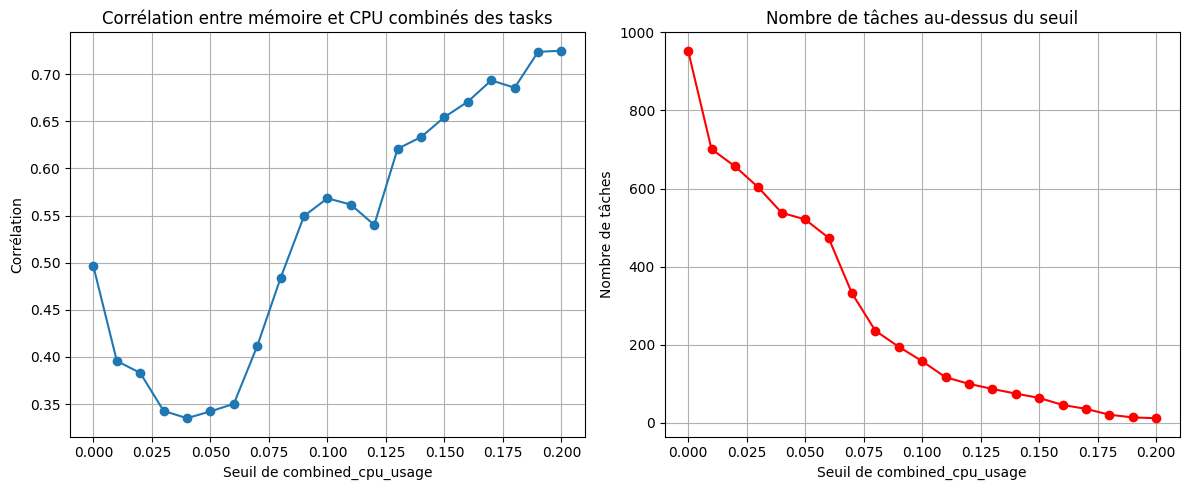

In [44]:
# Définition d'une liste de seuils pour combined_cpu_usage
thresholds = [k/100 for k in range(0, 21)]  # de 0.00 à 0.20
correlation_results = []

for thresh in thresholds:
    filtered = df_task_stats_joined.filter(F.col("combined_cpu_usage") >= thresh)
    count = filtered.count()
    # Calcul de la corrélation si le nombre de lignes est suffisant
    corr_val = filtered.stat.corr("combined_memory_usage", "combined_cpu_usage") if count > 1 else None
    correlation_results.append((thresh, count, corr_val))
    #print(f"Threshold: {thresh}, Count: {count}, Correlation: {corr_val}")

# Extraction des résultats pour la visualisation
thresh_list = [x[0] for x in correlation_results]
counts_list = [x[1] for x in correlation_results]
corr_list = [x[2] for x in correlation_results]

# Visualisation des résultats
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(thresh_list, corr_list, marker='o')
plt.title("Corrélation entre mémoire et CPU combinés des tasks")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Corrélation")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(thresh_list, counts_list, marker='o', color='red')
plt.title("Nombre de tâches au-dessus du seuil")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Nombre de tâches")
plt.grid(True)

plt.tight_layout()
plt.show()

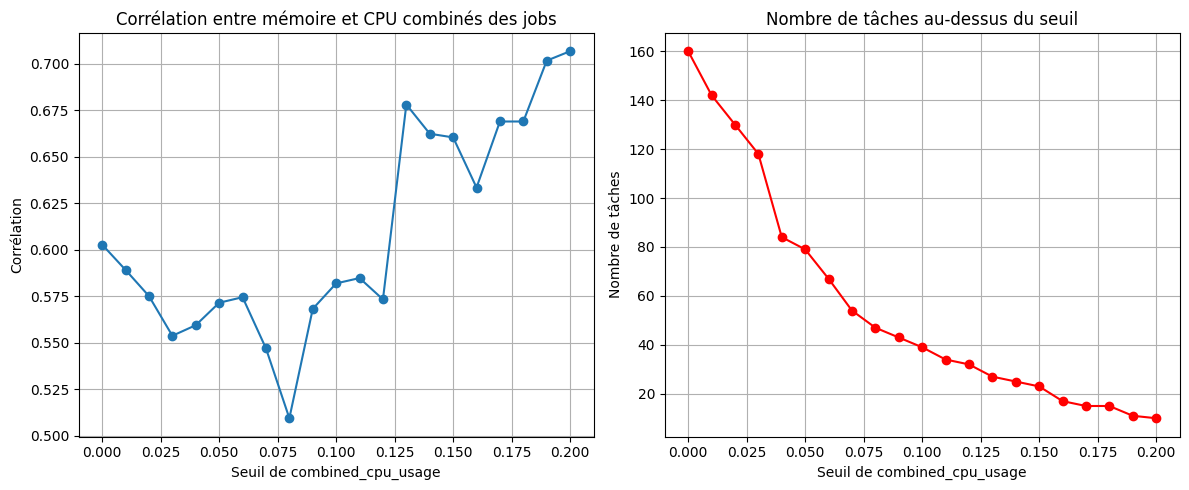

In [45]:
# Définition d'une liste de seuils pour combined_cpu_usage
thresholds = [k/100 for k in range(0, 21)]  # de 0.00 à 0.20
correlation_results = []

for thresh in thresholds:
    filtered = df_job_stats_joined.filter(F.col("combined_cpu_usage") >= thresh)
    count = filtered.count()
    # Calcul de la corrélation si le nombre de lignes est suffisant
    corr_val = filtered.stat.corr("combined_memory_usage", "combined_cpu_usage") if count > 1 else None
    correlation_results.append((thresh, count, corr_val))
    #print(f"Threshold: {thresh}, Count: {count}, Correlation: {corr_val}")

# Extraction des résultats pour la visualisation
thresh_list = [x[0] for x in correlation_results]
counts_list = [x[1] for x in correlation_results]
corr_list = [x[2] for x in correlation_results]

# Visualisation des résultats
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(thresh_list, corr_list, marker='o')
plt.title("Corrélation entre mémoire et CPU combinés des jobs")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Corrélation")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(thresh_list, counts_list, marker='o', color='red')
plt.title("Nombre de tâches au-dessus du seuil")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Nombre de tâches")
plt.grid(True)

plt.tight_layout()
plt.show()

### 📊 Analyse des résultats

- Les courbes obtenus pour les jobs et les tasks sont globalement similaire, celles des jobs sont moins lisses, cela peut être expliqué au faible nombre de jobs (160).
- La **corrélation entre mémoire et CPU** est relativement faible pour les tâches à faible consommation de CPU, mais elle augmente significativement à partir d’un seuil de 0.08, atteignant **0.72** pour les tâches les plus gourmandes en CPU et **0.70** pour les jobs les plus gourmands en CPU.
- Cette tendance suggère que **les tâches et les jobs fortement conssomateurs de CPU nécessitent également plus de mémoire**, expliquant ainsi une meilleure corrélation à ces seuils élevés.
- Le **nombre de tâches décroît exponentiellement** avec l’augmentation du seuil combined_cpu_usage, indiquant que **la majorité des tâches ont une faible utilisation CPU**.
- Avec un seuillage de **0.1**, il ne reste qu’environ **150 tâches**, et à **0.2**, seulement **12**, montrant que **les jobs intensifs en CPU sont rares** mais fortement corrélés avec une forte consommation mémoire.
- Cette distribution explique pourquoi la corrélation devient plus marquée aux seuils élevés : seules **les tâches les plus exigeantes en ressources subsistent**.

**Conclusion** : L’analyse met en évidence que les **jobs les plus dominants en CPU sont aussi ceux qui consomment le plus de mémoire**, ce qui pourrait être exploré davantage en analysant leur **priorité, type et impact global sur le cluster**. 

## Scatter Plot

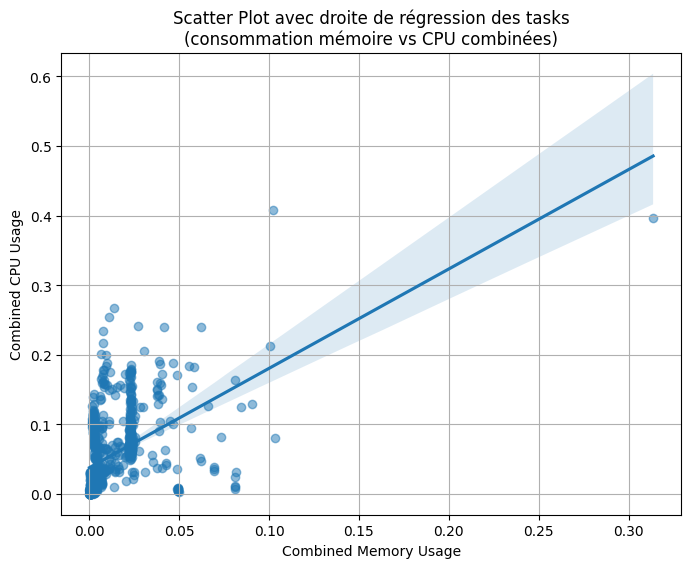

In [46]:
# Convertir le DataFrame Spark en Pandas (attention : cette opération doit être faite sur un échantillon ou un DataFrame de taille raisonnable)
df_task_pd = df_task_stats_joined.select("combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(8,6))
sns.regplot(x="combined_memory_usage", y="combined_cpu_usage", data=df_task_pd, scatter_kws={'alpha':0.5})
plt.title("Scatter Plot avec droite de régression des tasks\n(consommation mémoire vs CPU combinées)")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Combined CPU Usage")
plt.grid(True)
plt.show()

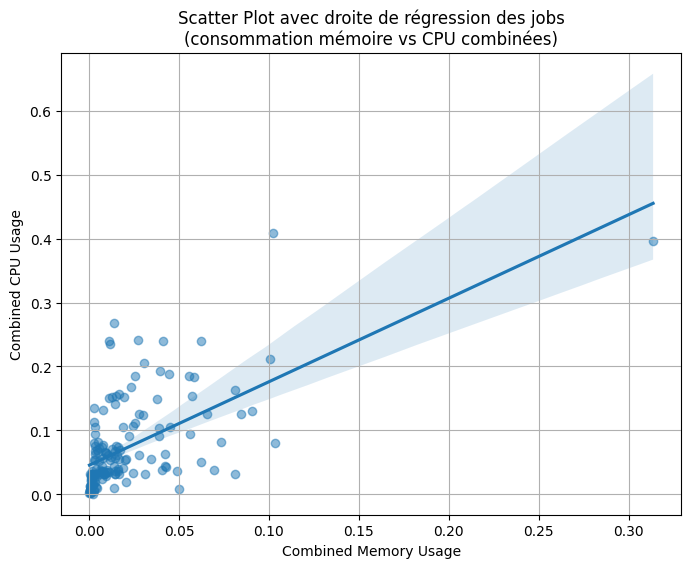

In [47]:
# Convertir le DataFrame Spark en Pandas (attention : cette opération doit être faite sur un échantillon ou un DataFrame de taille raisonnable)
df_job_pd = df_job_stats_joined.select("combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(8,6))
sns.regplot(x="combined_memory_usage", y="combined_cpu_usage", data=df_job_pd, scatter_kws={'alpha':0.5})
plt.title("Scatter Plot avec droite de régression des jobs\n(consommation mémoire vs CPU combinées)")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Combined CPU Usage")
plt.grid(True)
plt.show()

### 📊 Analyse du Scatter Plot (Mémoire vs CPU combinés)
Dans le cas des tasks et des jobs d'après les scatter plots, la relation entre la consommation mémoire combinée (combined_memory_usage) et la consommation CPU combinée (combined_cpu_usage) présente des caractéristiques communes :

- La droite de régression dans chacun des graphiques affiche une tendance **croissante**, soulignant une **corrélation positive** entre la mémoire et le CPU.
- Une **grande dispersion** des points est observée, notamment pour les faibles valeurs de mémoire et de CPU, suggérant que la relation n'est pas strictement linéaire.
- La majorité des observations se situe dans une zone de **faible consommation mémoire** (< 0.05) et de CPU, même si quelques cas présentent une **consommation mémoire nettement plus élevée** (au-delà de 0.10).
- L’**intervalle de confiance** (représenté par une bande bleue autour de la droite) s’élargit pour les valeurs élevées, indiquant une **incertitude accrue** sur la relation dans cette zone.  

En conclusion, que ce soit pour les tâches ou pour les jobs, on observe une **corrélation positive** entre l'utilisation de la mémoire et du CPU, **particulièrement marquée chez les entités ayant une forte consommation**. Une analyse plus approfondie des cas extrêmes pourrait aider à mieux comprendre ces tendances dans les deux contextes.

## Histogrammes 

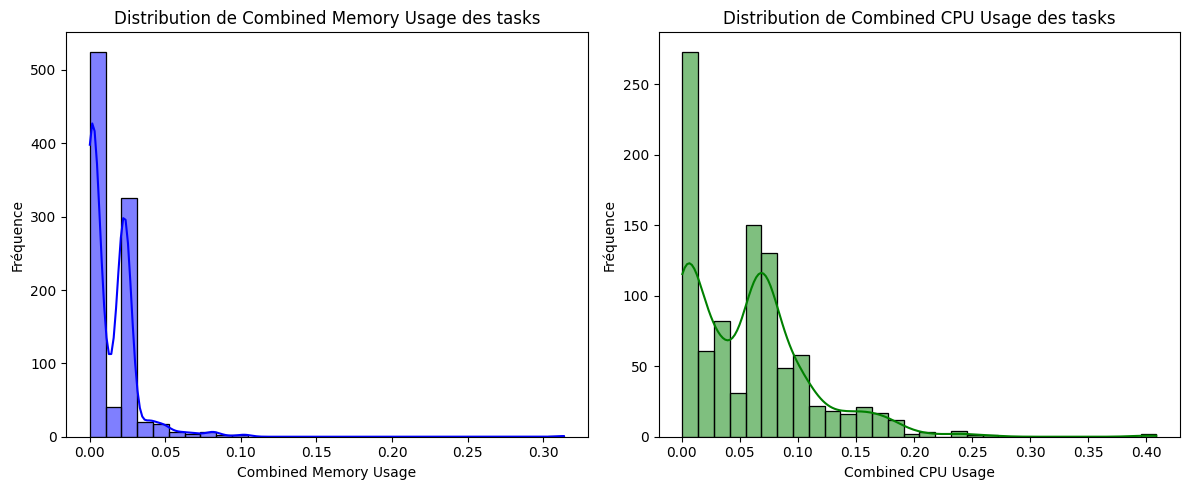

In [48]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df_task_pd["combined_memory_usage"], bins=30, kde=True, color='blue')
plt.title("Distribution de Combined Memory Usage des tasks")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
sns.histplot(df_task_pd["combined_cpu_usage"], bins=30, kde=True, color='green')
plt.title("Distribution de Combined CPU Usage des tasks")
plt.xlabel("Combined CPU Usage")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

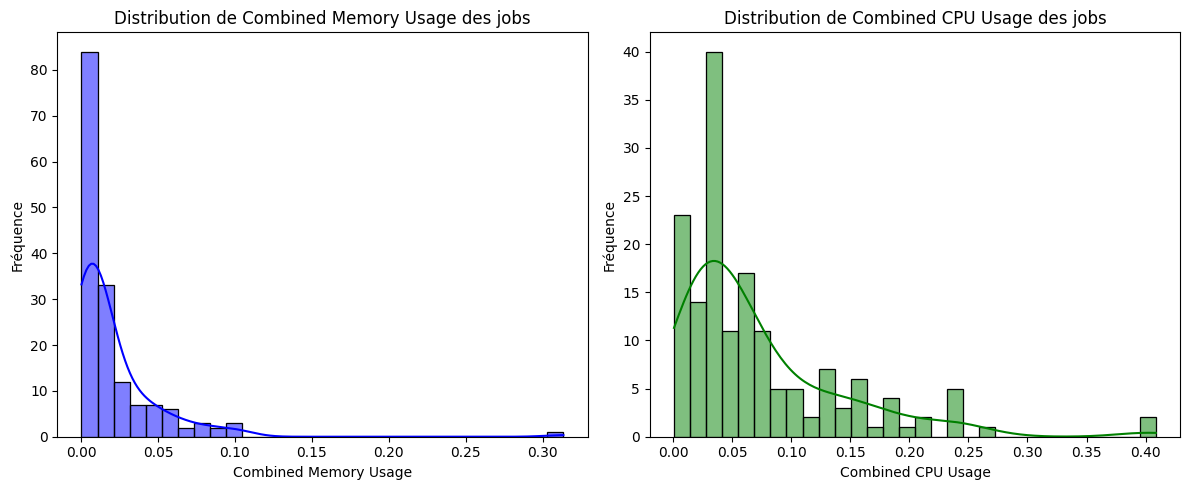

In [49]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df_job_pd["combined_memory_usage"], bins=30, kde=True, color='blue')
plt.title("Distribution de Combined Memory Usage des jobs")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
sns.histplot(df_job_pd["combined_cpu_usage"], bins=30, kde=True, color='green')
plt.title("Distribution de Combined CPU Usage des jobs")
plt.xlabel("Combined CPU Usage")
plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

### 📊 Analyse des distributions de consommation mémoire et CPU

- Les histogrammes illustrent la distribution des valeurs de **combined_memory_usage** et **combined_cpu_usage**, accompagnés d’une **courbe de densité (KDE)** pour mieux visualiser leur répartition.
- La distribution de la **consommation mémoire** est fortement **asymétrique à droite**, avec une grande majorité des tâches ayant une consommation **très faible (< 0.05)** et quelques outliers consommant davantage.
- La **consommation CPU** suit une distribution similaire mais légèrement plus étalée, indiquant qu’un plus grand nombre de tâches utilisent des valeurs intermédiaires de CPU, avec une **concentration autour de 0.02 - 0.05**.
- Les deux distributions montrent que la majorité des tâches ont une **faible consommation de ressources**, mais qu'il existe une queue longue, suggérant l'existence de **jobs dominants en mémoire et CPU**.

Ainsi, la plupart des tâches utilisent très peu de mémoire et de CPU, mais une **minorité de tâches fortement consommatrices pourrait impacter les performances du cluster**.

## Boxplots par classe de priorité


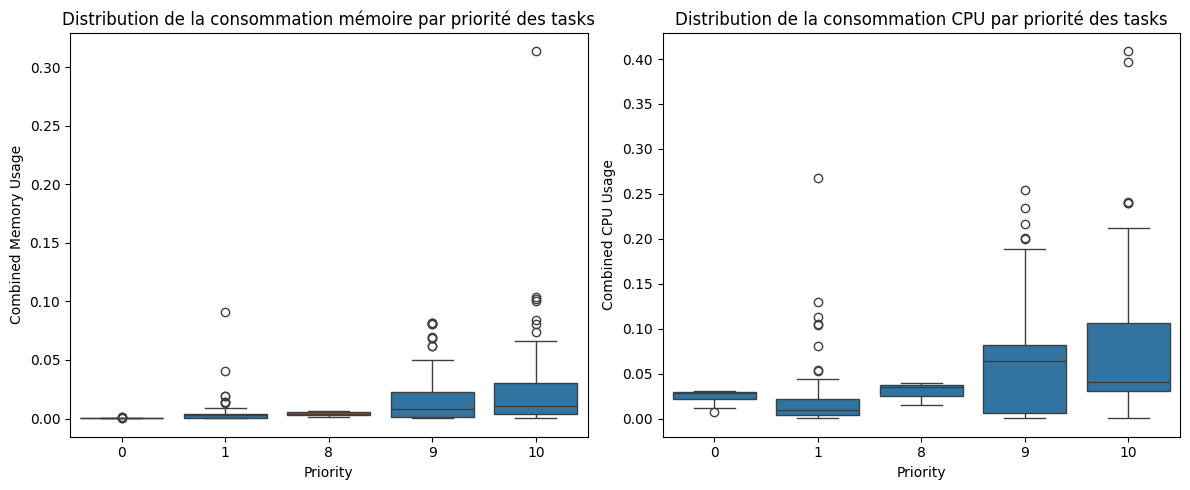

In [50]:
df_task_pd_priority= df_task_stats_joined.select("priority", "combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x="priority", y="combined_memory_usage", data=df_task_pd_priority)
plt.title("Distribution de la consommation mémoire par priorité des tasks")
plt.xlabel("Priority")
plt.ylabel("Combined Memory Usage")

plt.subplot(1,2,2)
sns.boxplot(x="priority", y="combined_cpu_usage", data=df_task_pd_priority)
plt.title("Distribution de la consommation CPU par priorité des tasks")
plt.xlabel("Priority")
plt.ylabel("Combined CPU Usage")

plt.tight_layout()
plt.show()

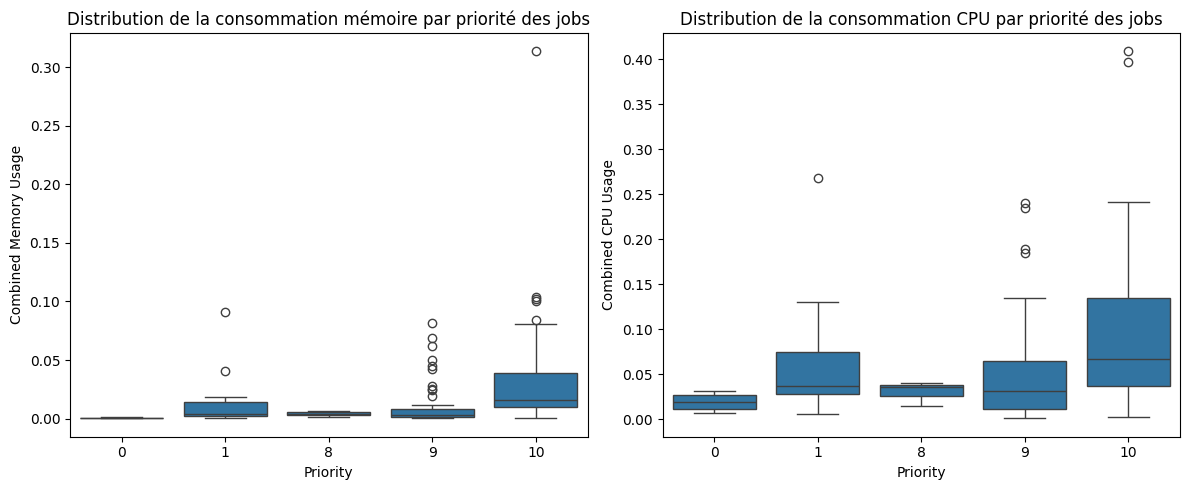

In [51]:
df_job_pd_priority = df_job_stats_joined.select("priority", "combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x="priority", y="combined_memory_usage", data=df_job_pd_priority)
plt.title("Distribution de la consommation mémoire par priorité des jobs")
plt.xlabel("Priority")
plt.ylabel("Combined Memory Usage")

plt.subplot(1,2,2)
sns.boxplot(x="priority", y="combined_cpu_usage", data=df_job_pd_priority)
plt.title("Distribution de la consommation CPU par priorité des jobs")
plt.xlabel("Priority")
plt.ylabel("Combined CPU Usage")

plt.tight_layout()
plt.show()

### 📊 Analyse des boxplots par classe de priorité

- Ces **boxplots** permettent de visualiser la répartition de la **consommation mémoire et CPU** en fonction de la **priorité des tâches**.
- On observe que les tâches avec une **priorité plus élevée (9 et 10)** ont tendance à consommer **plus de mémoire et de CPU**, bien que la majorité des valeurs restent relativement faibles.
- Les **médianes** restent similaires pour les priorités faibles (0, 1, 8), mais il y a une **plus grande variabilité** et davantage d'**outliers** pour les tâches de **priorité 9 et 10**, suggérant que certains jobs critiques sont plus gourmands en ressources.
- Le **nombre d'outliers** augmente significativement pour les priorités élevées, indiquant qu'un petit nombre de tâches consomment **beaucoup plus de ressources que la majorité**.

Les tâches à **priorité élevée** semblent avoir **une plus grande consommation de mémoire et CPU**, mais avec une forte variabilité.

## Heatmap de la matrice de corrélation

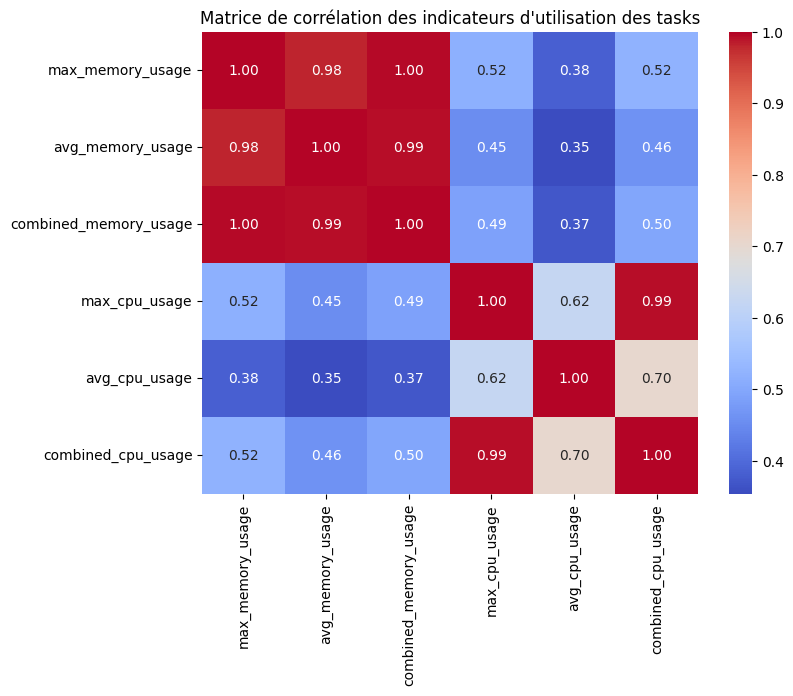

In [52]:
# Sélectionner plusieurs colonnes d'intérêt
df_task_pd_corr = df_task_stats_joined.select(
    "max_memory_usage", "avg_memory_usage", "combined_memory_usage",
    "max_cpu_usage", "avg_cpu_usage", "combined_cpu_usage"
).toPandas()

corr_matrix_task = df_task_pd_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_task, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des indicateurs d'utilisation des tasks")
plt.show()


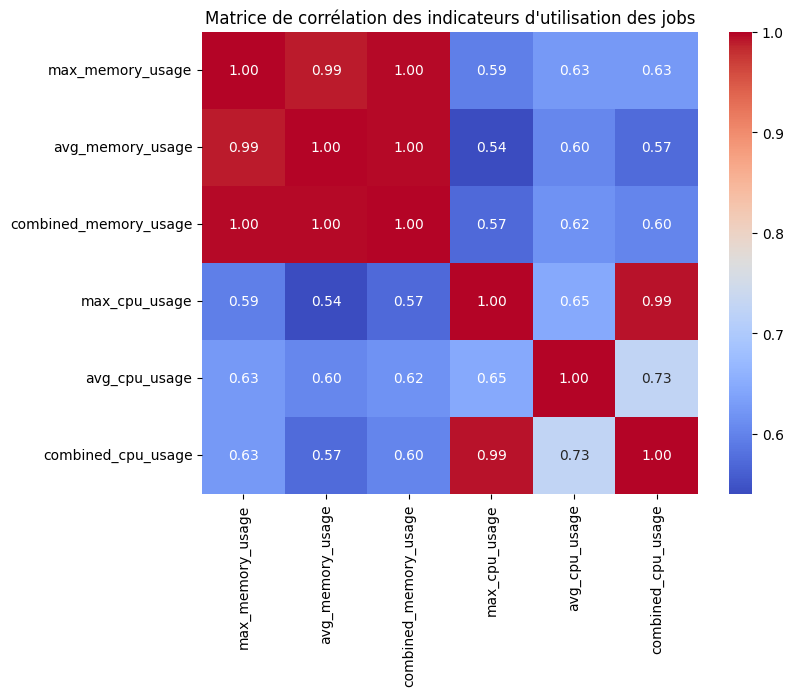

In [53]:
# Sélectionner plusieurs colonnes d'intérêt
df_job_pd_corr = df_job_stats_joined.select(
    "max_memory_usage", "avg_memory_usage", "combined_memory_usage",
    "max_cpu_usage", "avg_cpu_usage", "combined_cpu_usage"
).toPandas()

corr_matrix_job = df_job_pd_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_job, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation des indicateurs d'utilisation des jobs")
plt.show()


### 📊 Analyse de la matrice de corrélation des indicateurs d'utilisation

- Cette matrice montre la **corrélation** entre différents indicateurs d'utilisation de la mémoire et du CPU.
- Les métriques de **mémoire (max, avg, combined)** sont **très fortement corrélées entre elles** (≥ 0.98), indiquant que la consommation maximale et moyenne de mémoire évoluent de manière similaire.
- Les **indicateurs CPU** (max, avg, combined) présentent aussi des **corrélations élevées**, en particulier entre max_cpu_usage et combined_cpu_usage (0.99).
- La corrélation entre **mémoire et CPU** est **modérée** (~0.45 à 0.52), ce qui confirme que **les tâches gourmandes en mémoire ne sont pas systématiquement celles qui consomment le plus de CPU**, bien qu'il y ait une certaine relation.
- avg_cpu_usage a une **meilleure corrélation avec max_cpu_usage (0.62)** qu'avec les indicateurs mémoire, montrant que les tâches à forte consommation CPU ont souvent des pics élevés.

Les métriques mémoire et CPU sont **fortement corrélées au sein de leur propre catégorie**, mais leur relation intercatégories est plus faible. Cela signifie que **certains jobs dominants en CPU ne sont pas nécessairement dominants en mémoire et vice versa**.

# 7. Conclusion
L’analyse de la **trace Google Cluster** a permis de mettre en évidence plusieurs tendances et caractéristiques clés de l’utilisation des ressources dans un environnement de calcul distribué.

### **Principaux enseignements**
- **Les jobs dominants** en mémoire et en CPU ont été identifiés, montrant que seuls **quelques jobs consomment la majorité des ressources**.
- La **corrélation entre mémoire et CPU** est **modérée**, indiquant que les tâches fortement consommatrices en CPU ne sont pas systématiquement gourmandes en mémoire, bien que certaines tendances suggèrent un lien pour les jobs les plus exigeants.
- L’analyse des **priorités des tâches** révèle que les **jobs à haute priorité** (9 et 10) ont une **variabilité accrue** en termes de consommation, avec un nombre plus important d'outliers.
- Les **distributions de la consommation** mémoire et CPU montrent une forte **asymétrie**, avec une majorité de tâches consommant peu de ressources et **une minorité de jobs fortement consommateurs impactant l’ensemble du cluster**.

### **Perspectives et optimisations**
- Il pourrait être intéressant d’analyser plus en détail **l’impact des jobs dominants** sur la performance globale du cluster et d’examiner des stratégies pour améliorer leur **allocation des ressources**.
- L’étude des **jobs atypiques**, notamment ceux ayant une **forte consommation CPU mais faible mémoire (et inversement)**, pourrait aider à identifier des optimisations possibles pour la gestion des workloads.
- Une approche basée sur **l’apprentissage automatique** pourrait être envisagée pour **prédire** l’utilisation des ressources en fonction des caractéristiques des jobs et optimiser la répartition des tâches.

En conclusion, cette étude démontre l’importance d’une **analyse fine des traces d’utilisation** pour comprendre et améliorer l’efficacité des infrastructures HPC. 
L’exploitation de ces résultats pourrait conduire à une **gestion plus efficace des ressources**, réduisant ainsi les coûts et améliorant la performance des clusters de calcul.  
